In [3]:
import pandas as pd
import numpy as np
from numpy.random import uniform
import os
#!pip install yfinance
import yfinance as yf

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt

## Data Preparation

In [4]:
S_AND_P_URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

def get_s_and_p_tickers() -> list:
    '''
    Get a list of all tickers currently in the S&P500 index.
    '''
    return pd.read_html(S_AND_P_URL)[0]['Symbol'].tolist()
    

In [5]:
data = yf.download(
        tickers = get_s_and_p_tickers(),
        period = '5y',
        interval = '1d',
        group_by = 'ticker',
        threads = True,
    )

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [6]:
data = data.xs("Adj Close",level=1,axis=1)

In [7]:
data.head()

,EPAM,C,CMA,FISV,NVR,CARR,PPG,GM,DVA,DE,...,WHR,KEY,CCL,CSCO,NTRS,MET,BDX,MO,PCAR,GPC
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-16 00:00:00,103.610001,63.094948,66.460754,64.769997,3276.350098,NaN,106.237946,39.353661,55.639999,125.655632,...,142.390594,15.279279,60.177471,32.021938,84.990646,43.914265,204.146500,49.444649,60.199310,75.108971
2017-11-17 00:00:00,103.699997,62.795628,67.062469,64.195000,3258.469971,NaN,106.070229,39.606396,54.910000,126.738472,...,144.593597,15.430977,60.543175,32.039795,85.317154,44.007984,203.031403,49.849941,57.599617,75.231255
2017-11-20 00:00:00,103.629997,63.429493,67.630295,64.160004,3317.310059,NaN,107.048645,40.508999,54.759998,127.811943,...,144.418762,15.557388,60.460896,32.575279,85.643646,44.280647,204.128098,49.407139,58.471958,75.344803
2017-11-21 00:00:00,105.949997,63.720013,67.291306,64.135002,3377.000000,NaN,107.477295,40.590233,55.169998,129.968307,...,147.635864,15.405691,61.256321,32.709148,85.670845,44.059113,209.040054,49.272038,58.463299,75.074036
2017-11-22 00:00:00,105.820000,63.614365,67.240456,63.855000,3417.219971,NaN,107.412056,39.976463,55.389999,135.587860,...,145.677628,15.304563,61.477222,32.530655,85.607361,44.059113,206.643967,49.151951,58.618774,75.912552


In [8]:
data = data.pct_change() # get returns of Adj. Close price
data.iloc[0] = 0 # first row is null, switch to 0

In [9]:
# drop the entries that are Null
missing_percentage = data.isnull().mean().sort_values(ascending=False)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

In [10]:
X = data.T

In [11]:
mean_change = np.mean(X,1) * 256
total_vol = np.std(X,1) * np.sqrt(256)

## Agglomerative Clustering

In [12]:
# 11 clusters for the 11 sectors of the s&p500
clustering = AgglomerativeClustering(n_clusters=11,).fit(X)

In [13]:
data_agglom = pd.DataFrame({"Ticker":X.index,"Label":clustering.labels_})

In [14]:
data_agglom.sort_values("Label")

,Ticker,Label
489,GPC,0
176,ZBRA,0
177,SHW,0
178,CHRW,0
360,NWS,0
...,...,...
82,NXPI,10
83,QCOM,10
222,NVDA,10
385,AVGO,10


In [29]:
data_agglom.set_index('Ticker',inplace=True)

In [30]:
# Technology Stocks
# Apple.com vs Microsoft
data_agglom.loc['GOOG'] == data_agglom.loc['MSFT']

Label    True
dtype: bool

In [31]:
# Financial Stocks
# Goldman Sachs vs. Morgan Stanley
data_agglom.loc['GS'] == data_agglom.loc['MS']

Label    True
dtype: bool

In [32]:
# Pharma Stocks
# Abbvie vs. Elly Lily
data_agglom.loc['ABBV'] == data_agglom.loc['LLY']

Label    True
dtype: bool

In [33]:
# Energy Sector Stocks
# Occidental Petroleum vs. Chevron
data_agglom.loc['CVX'] == data_agglom.loc['OXY']

Label    True
dtype: bool

Just by testing a small sample of stocks from different sectors, I find that the hierarchial (agglomorative) clustering algorithm with n_clusters = 11, correctly classifies companies into their sector, a win for the algorithm

In [34]:
data_agglom['mean_change'] = mean_change

data_agglom['volatility'] = total_vol

<AxesSubplot: xlabel='volatility', ylabel='mean_change'>

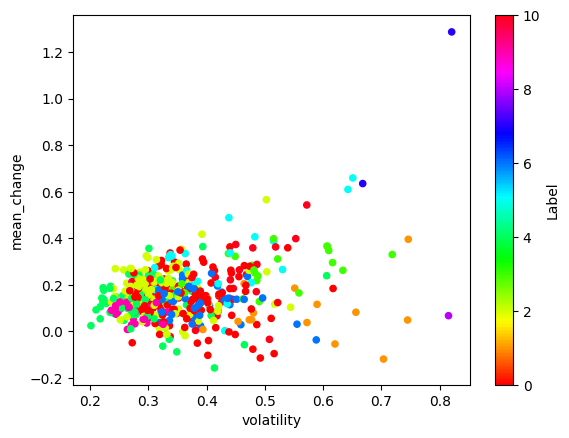

In [35]:
data_agglom.plot.scatter(x='volatility',
                               y='mean_change',
                               c ='Label',
                               colormap='hsv')

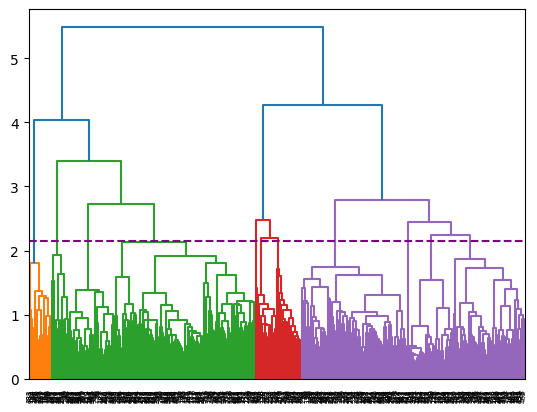

In [38]:
dend = hierarchy.dendrogram(hierarchy.linkage(X, method='ward'))
plt.axhline(y=2.15, color='purple', linestyle='--')

In [ ]:
# dendogram is consistant with my estiamte of the 11 sectors for the s&p500. The dendogram shows that 11 is an
# appropriate number of clusters to group the data with.

## K-Means

In [39]:
# Normalizer for use in pipeline
normalizer = Normalizer()

# Create a KMeans model with 10 clusters: kmeans
kmeans = KMeans(n_clusters=11, max_iter=1000)

# Make a pipeline chaining normalizer and kmeans: pipeline
pipeline = make_pipeline(normalizer, kmeans)

# Fit pipeline to the daily price movements
pipeline.fit(X)

print(kmeans.inertia_)

219.24094004227095


In [40]:
# Predict the cluster labels: labels
labels = pipeline.predict(X)

# Create a DataFrame aligning labels and companies: df
kmeans_df = pd.DataFrame({'labels': labels, 'companies': X.index})

# Display df sorted by cluster label
print(kmeans_df.sort_values('labels'))

     labels companies
79        0       TMO
41        0      BIIB
205       0      EQIX
312       0      IDXX
161       0      ISRG
..      ...       ...
330      10        GD
338      10        RL
340      10       VFC
311      10       AME
489      10       GPC

[490 rows x 2 columns]


In [41]:
kmeans_df.set_index('companies',inplace=True)

kmeans_df['mean_change'] = mean_change

kmeans_df['volatility'] = total_vol

<AxesSubplot: xlabel='volatility', ylabel='mean_change'>

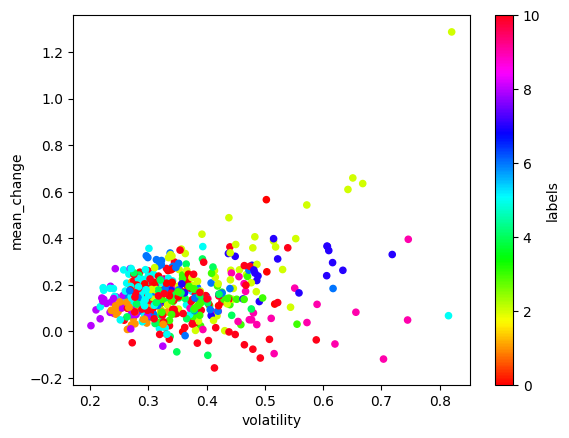

In [42]:
kmeans_df.plot.scatter(x='volatility',
                               y='mean_change',
                               c ='labels',
                               colormap='hsv')

In [43]:
# Technology Stocks
# Apple.com vs Microsoft
kmeans_df.loc['AAPL'] == kmeans_df.loc['MSFT']

labels          True
mean_change    False
volatility     False
dtype: bool

In [44]:
# Financial Stocks
# Goldman Sachs vs. Morgan Stanley
kmeans_df.loc['GS'] == kmeans_df.loc['MS']

labels          True
mean_change    False
volatility     False
dtype: bool

In [45]:
# Pharma Stocks
# Abbvie vs. Elly Lily
kmeans_df.loc['ABBV'] == kmeans_df.loc['LLY']

labels          True
mean_change    False
volatility     False
dtype: bool

In [46]:
# Energy Sector Stocks
# Occidental Petroleum vs. Chevron
kmeans_df.loc['CVX'] == kmeans_df.loc['OXY']

labels          True
mean_change    False
volatility     False
dtype: bool

Just by testing a small sample of stocks from different sectors, I find that the k means algorithm with k = 11, correctly classifies companies into their sector, a win for the algorithm

## Agglomerative From Scratch

In [47]:
from scipy.spatial.distance import pdist, squareform

In [61]:
data = pd.DataFrame({'Variance':X.T.std() * np.sqrt(256), 'Returns': X.T.mean() * 256}, index= X.index)

In [73]:
# Euclidean Distance for initial distance matrix
X = data.values
Y = pdist(X, 'euclidean')
distance = squareform(Y)

In [65]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def get_centroids(X, clusters, i):
    
    groups = clusters[i, :]
    N = len(np.unique(groups))
    centroids = np.zeros((N, 2))
    n = np.zeros(N)
    # for every cluster
    for k in range(N):
        cluster = np.zeros((1, 2))
        # get all points in cluster
        for j in range(X.shape[0]):
            # if point is in cluster np.unique(groups)[k]
            if groups[j] == np.unique(groups)[k]:
                cluster = np.append(cluster, np.reshape(X[j, :], (1, 2)), axis=0)
                n[k] = n[k] + 1
        # drop initializing zeros and reshape
        cluster = np.reshape(np.delete(cluster, [0, 1]), (-1, 2))
        # compute centroid (and drop initializing zeros)

        centroids[k, :] = centeroidnp(cluster)

        # return the centroids of the clusters, the cluster id, and the number
        # of points in the cluster

    return centroids, np.unique(groups), n


def ward_distances(centroids, n):
    distances = np.zeros((centroids.shape[0], centroids.shape[0]))

    for i in range(len(distances)):
        for j in range(len(distances)):
            if i != j:
                a = centroids[j,:]
                b = centroids[i,:]
                
                distances[i, j] = n[i]*n[j] / (n[i]+n[j]) *((a-b)[0]**2+(a-b)[1]**2)
            else:
                distances[i,j] = np.Inf
    
    return distances

In [68]:
i=0
# initialize variable to store cluster labels throughout iterations
N = len(X)
clusters = np.zeros((N, N)).astype('int')
clusters[0, :] = np.arange(0, N)
clusters
mergers = np.zeros((N,2)).astype('int')
while i<N-2:
    # get centroids
    centroids, ids, n = get_centroids(X, clusters, i)

    # calculate ward distances
    distances = ward_distances(centroids, n)

    # find indices of the min distance between two points from ward distances
    idx1, idx2 = np.divmod(distances.argmin(), distances.shape[1])

    # find the cluster numbers of the indices
    clust1 = ids[idx1]
    clust2 = ids[idx2]

    # combine the two clusters

    temp = clusters[i, :]
    #print('Swapping Cluster %d for Cluster %d' % (clust2, clust1))
    mergers[i,:] = (clust2, clust1) # keep track of merges easily
    # find all members of cluster 2 and set old cluster 2 to cluster 1 (merge clusters)
    temp[temp == clust2] = clust1
    clusters[i+1, :] = temp  # update cluster tracker

    # iterate i for next loop
    i = i + 1


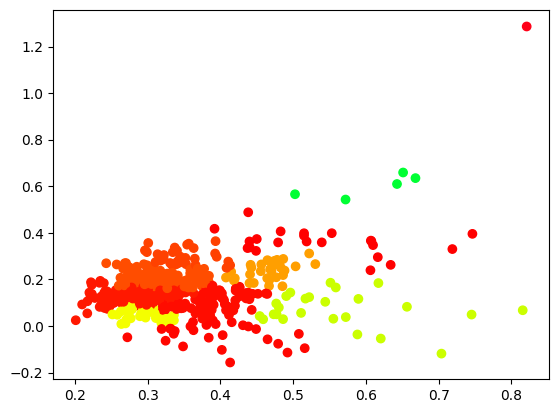

In [72]:
plt.scatter(X[:, 0], X[:, 1], c=clusters[-12,:], cmap="hsv")
plt.show()

## K-Means from Scratch

In [378]:
#Defining our function 
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x.loc[x.index[idx], :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x.loc[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points 

In [379]:
k = 11
label = kmeans(X,k,1000)

In [380]:
# Create a DataFrame aligning labels and companies: 
kmeans_scratch_df= pd.DataFrame({'labels': label, 'companies': X.index})

# Display df sorted by cluster label
print(kmeans_scratch_df.sort_values('labels'))

     labels companies
134       0       HPE
243       0       VMC
488       0       PWR
246       0      DISH
253       0       BEN
..      ...       ...
418      10       LNC
417      10       CMA
168      10       SYF
412      10       AIG
244      10       JPM

[490 rows x 2 columns]


In [381]:
kmeans_scratch_df.set_index('companies',inplace=True)

In [382]:
kmeans_scratch_df['mean_change'] = mean_change

kmeans_scratch_df['volatility'] = total_vol

<AxesSubplot:xlabel='volatility', ylabel='total_change'>

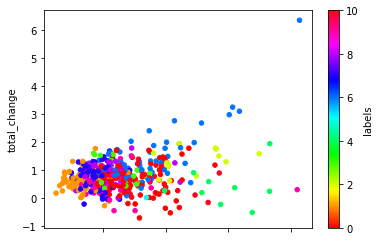

In [383]:
kmeans_scratch_df.plot.scatter(x='volatility',
                               y='mean_change',
                               c ='labels',
                               colormap='hsv')

It seems that when trying to classify the stocks by total return over the 5 years and volatility, the k means sklearn algorithm and the one I built from scratch perform similarly. None are able to classify perfectly, although they do a fine job.